# Predicting Forest Coverage Type to Predict Ecological Shifts

by: Carter Koehler

## Data Description and Prediction Task

Data retrieved from: https://www.kaggle.com/uciml/forest-cover-type-dataset

This dataset contains information on the forest coverage types from the Roosevelt National Forest in Colorado. The data consists of $12$ explanatory variables related to cartographic measurements of a particular area and a categorical encoding of what type of tree cover that area has. In particular, it has features on:

- elevation
- grade of slope (slope)
- direction of slope (aspect)
- distance to water
- distance to roads
- distance to fire points
- shade coverage at various times in the day
- wilderness area
- soil type

All of the categorical data (with the exception of the target variable) has already been one-hot encoded, meaning the the data we are dealing with already has quite a few more than $12$ columns.

All of this is well and good, but it begs the question why we would want to be able to predict the forest coverage of a particular block of forest. One possible application is as follows: If it happens that we are able to predict how a particular area of forest is covered, this gives us a good qualitative description of what flora is present in that area. However, if the cartographic features of that area were to change due to human or other influence, such that we would predict a different coverage type than is there currently, we should predict that that area is about to go through a severe ecological change. This will give administrators and rangers a chance to prepare for major changes in the forest's wildlife. Unfortunately, this application is difficult to test for directly, so we will settle for predicting the classes as is. Additionally, since we will be using this to test for changes in the environment, we will care as much about false negatives as false positives, since the precise classification will inform whether or nota change is correctly detected.

This of course brings into question what we might use as a suitable baseline. We will see in the exploratory stages of the analysis that the distribution of cover type changes significantly between wilderness areas. We will use this to derive our baseline, which will predict the most frequent cover type for each wilderness area. For our algorithm to be considered as successfully fulfilling our task, it should be able to beat this baseline to within a statistically significant margin.

Much of the analysis in this notebook, including the above description, follows from [work completed for the previous project](https://github.com/carterkoehler/evaluation-and-mlp) on using Multi-Layer Perceptrons. More extensive visualizations of the feature distributions and other aspects of the dataset can be found there. Only ones that are directly applicable to the current analysis will be reproduced here.

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['axes.grid'] = True

import os
import sys
from pprint import pprint

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD, Adagrad

In [3]:
filename = os.path.join(os.pardir, 'data', 'covtype.csv')
df_cov = pd.read_csv(filename)

## Basic Data Preparation

In [4]:
def un_one_hot(data, regex):
    data_filter = data.filter(regex=regex, axis=1)
    return data_filter.idxmax(1).rename(regex)

cov_reconstructed = pd.concat([df_cov.drop(df_cov.filter(regex='Wilderness_Area|Soil_Type'), axis=1), un_one_hot(df_cov, 'Soil_Type*').rename('Soil_Type'), un_one_hot(df_cov, 'Wilderness_Area*').rename('Wilderness_Area')], axis=1)

cov_reconstructed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 13 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Cover_Type                            581012 non-null int64
Soil_Type                             581012 non-null object
Wilderness_Area                       581012 non-null object
dtypes: int64(11), object(2)
memory usage: 57.6+ MB


As we will see later, the performance of a Wide and Deep Network will be greatly improved if it has several (or at least more than two) categorical variables. We should find one or two more numerical variables to bin and turn into categorical features before analyzing the whole set. One good candidate for this could be elevation. Let's start exploring the data.

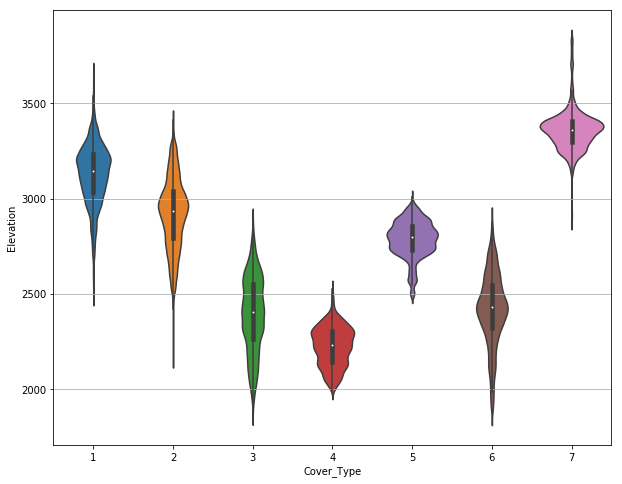

In [5]:
sns.violinplot(data=df_cov, x='Cover_Type', y='Elevation')
plt.show()

Our hopes of finding a qualitative shift in flora due to a quantitative shift in elevation may have just come through. There appear to be a few natural groupings, which we can exploit.

In [6]:
cov_reconstructed['Elevation_Cat'] = pd.cut(x=cov_reconstructed['Elevation'], bins=[0, 2300, 2600, 3300, 1e8], labels=['low', 'low_mid', 'mid', 'high'])

In [7]:
numerical = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

categorical = ['Soil_Type', 'Wilderness_Area', 'Elevation_Cat']

classes = ['Cover_Type']

In [8]:
from sklearn.preprocessing import StandardScaler

data_subsets = {
    'num' : cov_reconstructed.filter(numerical),
    'cat' : cov_reconstructed.filter(categorical),
    'target' : cov_reconstructed.filter(classes)
}

In [130]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

data_subsets['num'] = pd.DataFrame(StandardScaler().fit_transform(data_subsets['num']))
data_subsets['cat_int'] = data_subsets['cat'].apply(LabelEncoder().fit_transform)
data_subsets['cat_ohe'] = OneHotEncoder().fit_transform(data_subsets['cat_int'])

## Picking Evaluation Methods

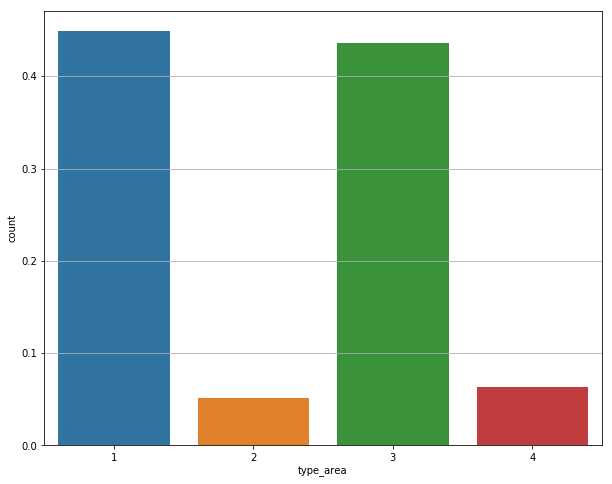

In [10]:
area_types = ['Wilderness_Area' + str(i) for i in range(1,5)]

area_counts = pd.DataFrame(np.zeros((len(area_types), 2)), index=area_types, columns=['type_area', 'count'])
area_counts['type_area'] = range(1,5)
for area in area_types:
    area_counts.loc[area, 'count'] = df_cov[area].sum() / df_cov[area].count()
    
sns.barplot(data=area_counts, x='type_area', y='count')
plt.show()

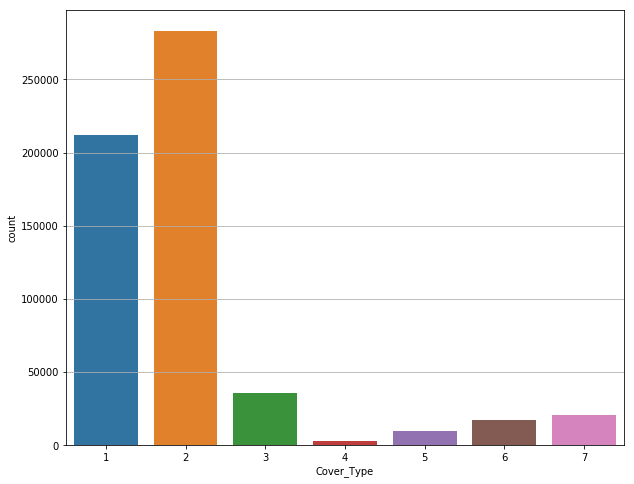

In [11]:
sns.countplot(data=df_cov, x='Cover_Type')
plt.show()

These plots tell us a bit about our dataset, specifically that its classes are unbalanced, and many of its categorical variables are greatly unbalanced. This will heavily inform our choice of cross-validation scheme and metric.

### Evaluation Metric

Examining the plot above and the imbalance in classes, we determine that an evaluation metric like accuracy will not work for our particular dataset. Take, for example the baseline from the previous analysis, which correctly predicts the two most frequent classes every time, but never predicts any other class, and misclassifies everything else. 

In [12]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import warnings 

warnings.filterwarnings('ignore')

high_accuracy = np.array(cov_reconstructed.Cover_Type)
high_accuracy[high_accuracy > 2] = 0

print('Accuracy score if we always predict 1 and 2 correctly is:\n {}'.format(accuracy_score(cov_reconstructed.Cover_Type, high_accuracy)))
print('--------------------------------------------------')
print('F1 macro score if we always predict 1 and 2 correctly is:\n {}'.format(f1_score(cov_reconstructed.Cover_Type, high_accuracy, average='macro')))

Accuracy score if we always predict 1 and 2 correctly is:
 0.8522044295126434
--------------------------------------------------
F1 macro score if we always predict 1 and 2 correctly is:
 0.25


In [241]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, average='macro')

As we can see, switching to an f1-score exposes the poor classifier for what it is, a mere guess, a pretender. Additionally, we are trying to distinguish changes in environment, so each class is vitally important to the efficacy of this predictor. Because of this and the class imbalance, we will stick to f1 with a macro-averaging scheme as our evaluation metric.

### Cross-Validation Scheme

Once again, we are haunted by the curse of unbalanced classes. This means that we will definitely need to use a more sophisticated method than simple k-fold validation. Since we have a larger dataset, it is likely impractical to do something along the lines of a shuffle-split, but we should certainly ensure that our method is stratified to ensure even class distributions. We will use all the default options for fold numbers, test sizes, etc. However, we will also break off $20\%$ of the data as a separate test set for final model evaluation.

To get good data on the cross-validation sets, we should have several of them. 10 ought to be a good balance between being easily computable and gathering enough information on the model effectiveness.

Additionally, when we estimate the variability of the classifier's performance, we will use a 5-fold outer loop for the test data.

## Crossing Features

Domain knowledge for plant growth indicates that many plants are largely separated simply by area, and even if conditions are similar in two different areas, they may have wildly different flora for largely historical reasons. Thus, it makes sense to cross Wilderness_Area with the other two categorical features. 

Additionally, soil type can behave differently at different altitudes. Whereas rocky soil at lower altitudes might mean that only hardier plants are able to thrive, at higher altitudes, such plants might just not grow. And if there is unstable, rocky terrain of the side of a mountain, then there is almost certainly nothing growing there. Fort interactions like these, it may be useful to memorize certain interactions between soil type and elevation

In [14]:
crossed_pairs = [
    ['Elevation_Cat', 'Soil_Type'],
    ['Soil_Type', 'Wilderness_Area'],
    ['Elevation_Cat', 'Wilderness_Area']
]

temp = {}
for pair in crossed_pairs:
    cross = LabelEncoder().fit_transform(data_subsets['cat'].filter(pair).apply(lambda x : '_'.join(x), axis=1))
    temp.update({'_'.join(pair): cross})

data_subsets['crossed'] = pd.DataFrame(temp)

## Modeling

### Generating Multiple Models

Let's start out with a fairly generic W&D Network layout, given our setup of features.

In [15]:
n_instances = df_cov.shape[0]
proportion_test = 0.2
n_train = int(n_instances * (1 - proportion_test))
n_test = n_instances - n_train
n_classes = np.max(data_subsets['target'].values)

In [195]:
def predict_categ(model, data):
    return(np.argmax(model.predict(data), axis=1))

### Generic D&W Model

In [226]:
# this implementation is, almost point-for-point, what can be found at https://github.com/eclarson/MachineLearningNotebooks/blob/master/10.%20Keras%20Wide%20and%20Deep.ipynb

# putting this all in a function would be nice, but there are far too many parameters to make that worth it

X_train = []
X_test = []
inputs = []
wide_branches = []
deep_branches = []

idx_train = np.sort(np.random.choice(np.arange(n_instances), size=n_train, replace=False))
idx_test = np.setdiff1d(np.arange(n_instances), idx_train, assume_unique=True)

y_train = data_subsets['target'].iloc[idx_train].values
y_test = data_subsets['target'].iloc[idx_test].values

for crossed_cat in data_subsets['crossed'].columns:
    input_layer = Input(shape=(1,), dtype='int32', name=crossed_cat)
    inputs.append(input_layer)
    X_train.append(data_subsets['crossed'][crossed_cat].iloc[idx_train].values)
    X_test.append(data_subsets['crossed'][crossed_cat].iloc[idx_test].values)
    
    n_categories = max(X_train[-1])+1
    emb = Embedding(input_dim=n_categories, 
                    output_dim=int(np.sqrt(n_categories)), 
                    input_length=1, name=crossed_cat+'_embed')(input_layer)
    flat = Flatten()(emb)
    wide_branches.append(flat)
    
wide = concatenate(wide_branches, name='wide_root')    
wide_train = Dense(units=20, activation='relu', name='wide_dense')(wide)

for cat_var in data_subsets['cat_int']:
    input_layer = Input(shape=(1,), dtype='int32', name=cat_var)
    inputs.append(input_layer)
    X_train.append(data_subsets['cat_int'][cat_var].iloc[idx_train].values)
    X_test.append(data_subsets['cat_int'][cat_var].iloc[idx_test].values)
    
    n_categories = max(X_train[-1]) + 1
    emb = Embedding(input_dim=n_categories,
                    output_dim=int(np.sqrt(n_categories)),
                    input_length=1, name=cat_var+'_embed')(input_layer)
    flat = Flatten()(emb)
    deep_branches.append(flat)

num_vars = data_subsets['num']

input_num = Input(shape=(num_vars.shape[1],), name='num_input')
inputs.append(input_num)
X_train.append(data_subsets['num'].iloc[idx_train].values)
X_test.append(data_subsets['num'].iloc[idx_test].values)

num_dense = Dense(units=20, activation='relu', name='num_dense')(input_num)
deep_branches.append(num_dense)

deep_gather = concatenate(deep_branches, name='deep_concat')
deep_node_1 = Dense(units=80, activation='relu', name='deep1')(deep_gather)
deep_node_2 = Dense(units=50, activation='relu', name='deep2')(deep_node_1)
deep_node_3 = Dense(units=20, activation='relu', name='deep3')(deep_node_2)

all_gather = concatenate([deep_node_3, wide_train], name='all_concat')
all_train = Dense(units=20, activation='relu', name='train_all')(all_gather)

final_branch = Dense(units=7, activation='sigmoid', name='final')(all_train)

model_generic = Model(inputs=inputs, outputs=final_branch)

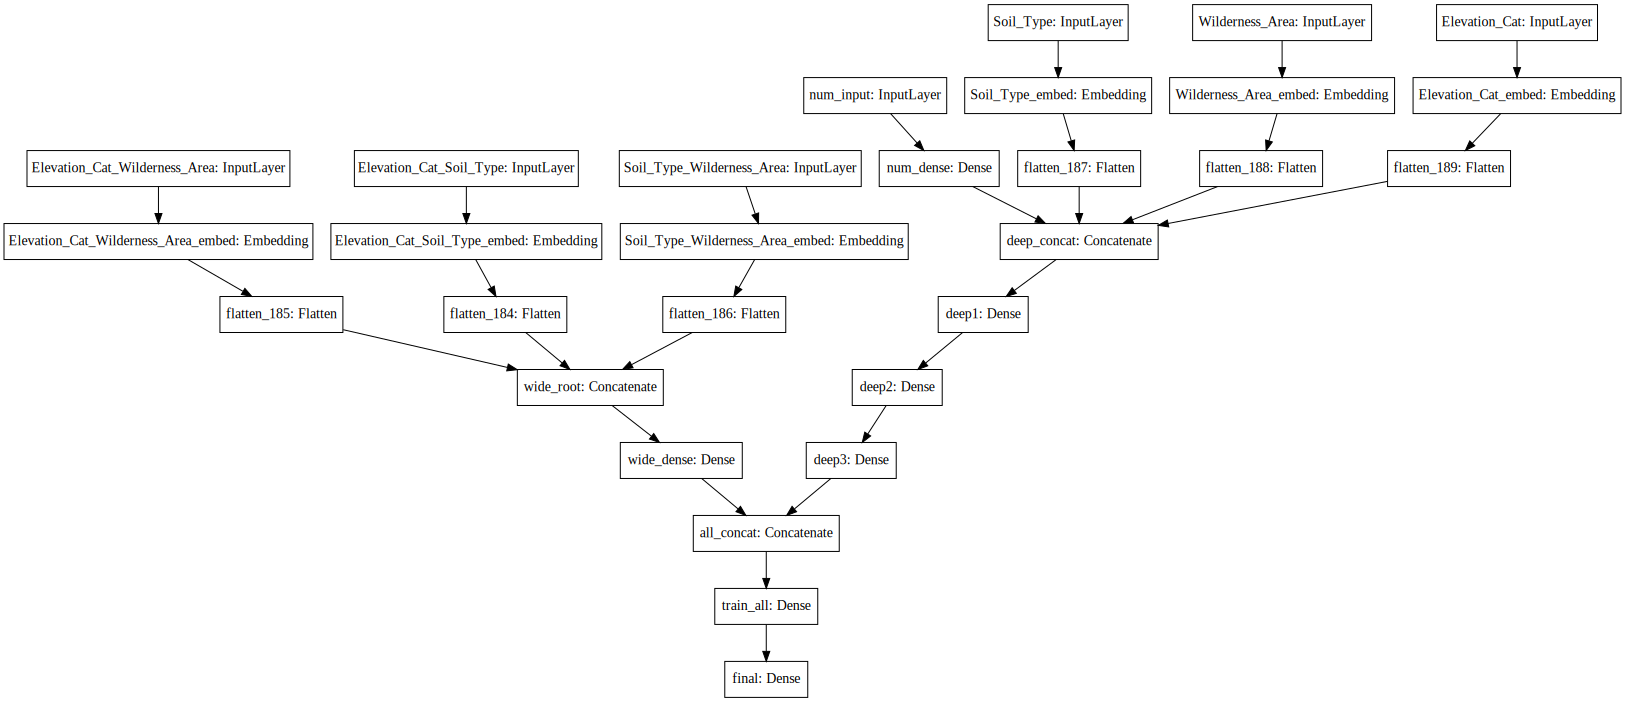

In [165]:
from IPython.display import SVG

SVG(model_to_dot(model_generic).create(prog='dot', format='svg'))

In [265]:
model_generic.compile(optimizer=SGD(lr=1e-2),
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

model_generic.reset_states()

history_generic = model_generic.fit(
    X_train,
    y_train-1,
    epochs=20,
    batch_size=10000,
    verbose=1,
    validation_data=(X_test, y_test-1)
)

Train on 464809 samples, validate on 116203 samples
Epoch 1/20
464809/464809 [==============================] - 4s 9us/step - loss: 1.8070 - acc: 0.5060 - val_loss: 1.7812 - val_acc: 0.4996
Epoch 2/20
464809/464809 [==============================] - 2s 5us/step - loss: 1.7560 - acc: 0.4984 - val_loss: 1.7304 - val_acc: 0.4927
Epoch 3/20
464809/464809 [==============================] - 2s 5us/step - loss: 1.7046 - acc: 0.4931 - val_loss: 1.6785 - val_acc: 0.4884
Epoch 4/20
464809/464809 [==============================] - 2s 5us/step - loss: 1.6514 - acc: 0.4893 - val_loss: 1.6241 - val_acc: 0.4854
Epoch 5/20
464809/464809 [==============================] - 3s 5us/step - loss: 1.5944 - acc: 0.4882 - val_loss: 1.5641 - val_acc: 0.4854
Epoch 6/20
464809/464809 [==============================] - 2s 5us/step - loss: 1.5294 - acc: 0.4882 - val_loss: 1.4935 - val_acc: 0.4854
Epoch 7/20
464809/464809 [==============================] - 2s 5us/step - loss: 1.4517 - acc: 0.4882 - val_loss: 1.4088 

F1 score of this model is 0.09336040343612635


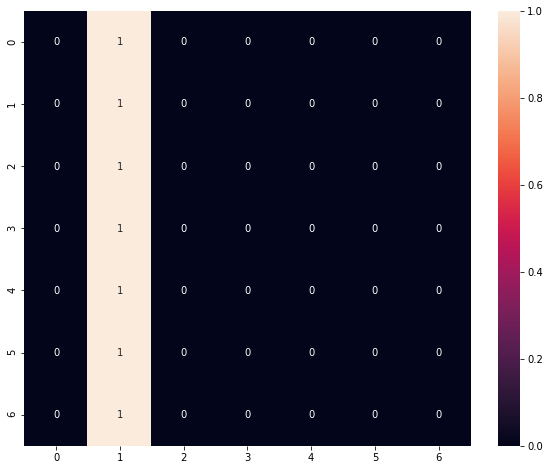

In [267]:
def evaluate_confusion(model, test_data, test_target, normalize=True, print_f1=True):
    yhat = predict_categ(model, test_data) + 1
    conf = confusion_matrix(test_target, yhat[:,np.newaxis])

    if normalize:
        conf = conf / np.unique(test_target, return_counts=True)[1][:, np.newaxis]
    if print_f1:
        print('F1 score of this model is {}'.format(f1_score(test_target, yhat, average='macro')))
        
    sns.heatmap(conf, annot=True)
    plt.show()
    
evaluate_confusion(model_generic, X_test, y_test)

This model is getting thrown out with last week's garbage. It is worse than the baseline and has no predictive value whatsoever. Let's try applying some base-level improvement techniques.

### D&W with Dropout

In [271]:
X_train = []
X_test = []
inputs = []
wide_branches = []
deep_branches = []

idx_train = np.sort(np.random.choice(np.arange(n_instances), size=n_train, replace=False))
idx_test = np.setdiff1d(np.arange(n_instances), idx_train, assume_unique=True)

y_train = data_subsets['target'].iloc[idx_train].values
y_test = data_subsets['target'].iloc[idx_test].values

for crossed_cat in data_subsets['crossed'].columns:
    input_layer = Input(shape=(1,), dtype='int32', name=crossed_cat)
    inputs.append(input_layer)
    X_train.append(data_subsets['crossed'][crossed_cat].iloc[idx_train].values)
    X_test.append(data_subsets['crossed'][crossed_cat].iloc[idx_test].values)
    
    n_categories = max(X_train[-1])+1
    emb = Embedding(input_dim=n_categories, 
                    output_dim=int(np.sqrt(n_categories)), 
                    input_length=1, name=crossed_cat+'_embed')(input_layer)
    flat = Flatten()(emb)
    wide_branches.append(flat)
    
wide = concatenate(wide_branches, name='wide_root')    
wide_train = Dense(units=20, activation='relu', name='wide_dense')(wide)
wide_dropout = Dropout(rate=0.2, name='wide_drop')(wide_train)

for cat_var in data_subsets['cat_int']:
    input_layer = Input(shape=(1,), dtype='int32', name=cat_var)
    inputs.append(input_layer)
    X_train.append(data_subsets['cat_int'][cat_var].iloc[idx_train].values)
    X_test.append(data_subsets['cat_int'][cat_var].iloc[idx_test].values)
    
    n_categories = max(X_train[-1]) + 1
    emb = Embedding(input_dim=n_categories,
                    output_dim=int(np.sqrt(n_categories)),
                    input_length=1, name=cat_var+'_embed')(input_layer)
    flat = Flatten()(emb)
    deep_branches.append(flat)

num_vars = data_subsets['num']

input_num = Input(shape=(num_vars.shape[1],), name='num_input')
inputs.append(input_num)
X_train.append(data_subsets['num'].iloc[idx_train].values)
X_test.append(data_subsets['num'].iloc[idx_test].values)

num_dense = Dense(units=20, activation='relu', name='num_dense')(input_num)
num_dropout = Dropout(rate=0.2, name='deep_drop')(num_dense)
deep_branches.append(num_dropout)

deep_gather = concatenate(deep_branches, name='deep_concat')
deep_node_1 = Dense(units=80, activation='relu', name='deep1')(deep_gather)
deep_node_1 = Dropout(rate=0.2, name='deep_drop_1')(deep_node_1)
deep_node_2 = Dense(units=50, activation='relu', name='deep2')(deep_node_1)
deep_node_2 = Dropout(rate=0.2, name='deep_drop_2')(deep_node_2)
deep_node_3 = Dense(units=20, activation='relu', name='deep3')(deep_node_2)
deep_node_3 = Dropout(rate=0.2, name='deep_drop_3')(deep_node_3)

all_gather = concatenate([deep_node_3, wide_dropout], name='all_concat')
all_train = Dense(units=20, activation='relu', name='train_all')(all_gather)
all_train = Dropout(rate=0.2, name='all_dropout')(all_train)

final_branch = Dense(units=7, activation='softmax', name='final')(all_train)

model_dropout = Model(inputs=inputs, outputs=final_branch)

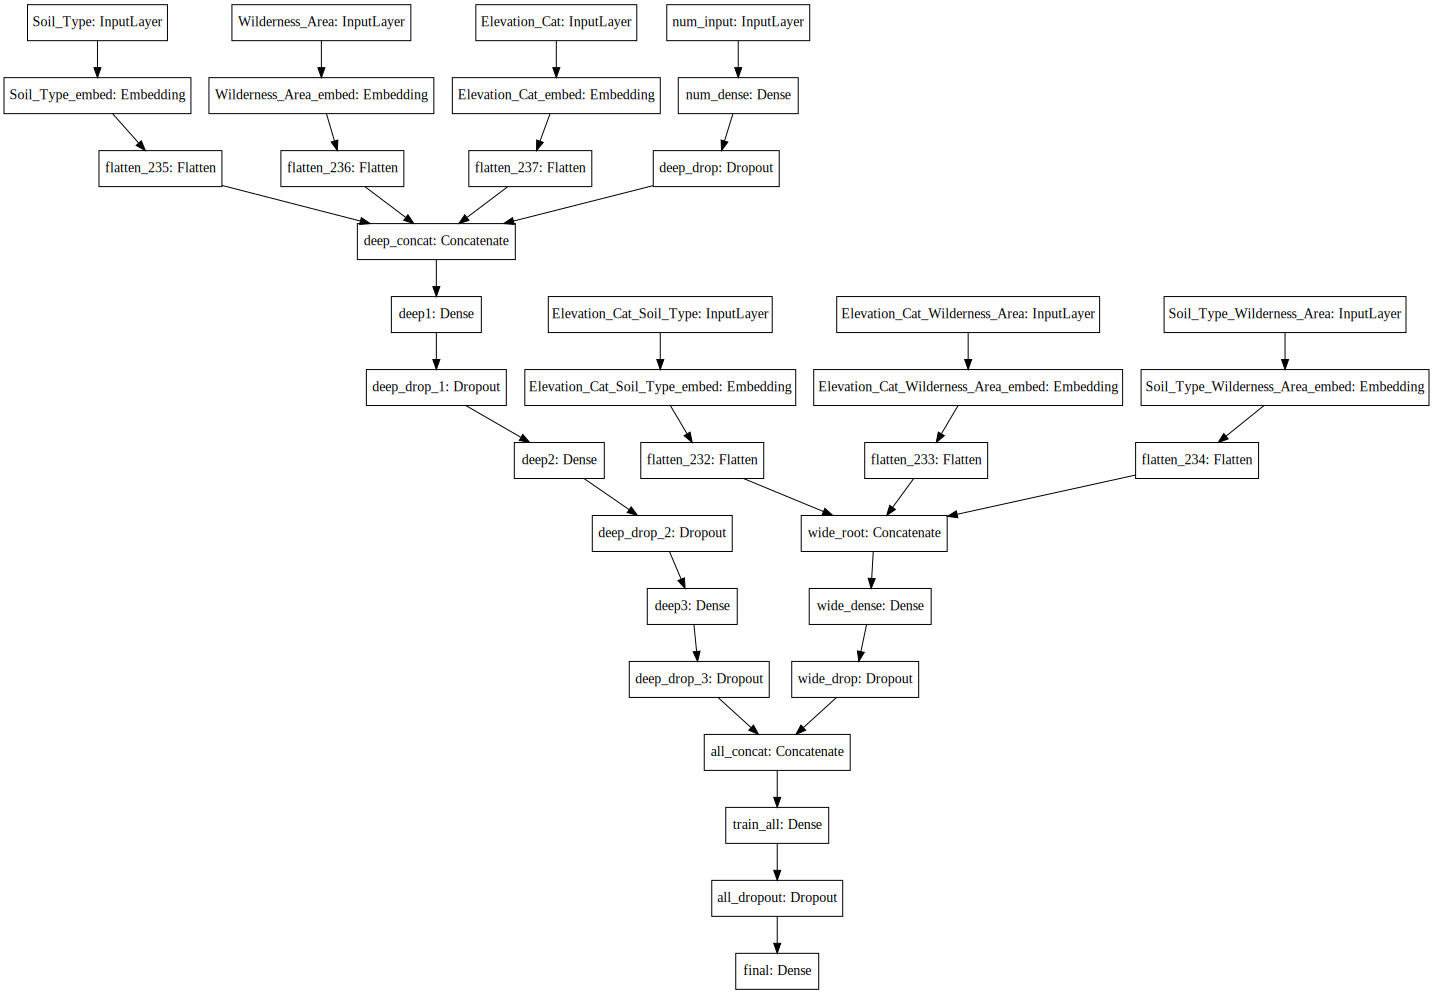

In [185]:
SVG(model_to_dot(model_dropout).create(prog='dot', format='svg'))

In [274]:
model_dropout.compile(optimizer=SGD(lr=1e-2),
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

model_dropout.reset_states()

history_dropout = model_dropout.fit(
    X_train,
    y_train-1,
    epochs=20,
    batch_size=10000,
    verbose=1,
    validation_data=(X_test, y_test-1)
)

Train on 464809 samples, validate on 116203 samples
Epoch 1/20
464809/464809 [==============================] - 6s 13us/step - loss: 1.8257 - acc: 0.3438 - val_loss: 1.6967 - val_acc: 0.4475
Epoch 2/20
464809/464809 [==============================] - 4s 8us/step - loss: 1.6043 - acc: 0.4285 - val_loss: 1.4864 - val_acc: 0.4752
Epoch 3/20
464809/464809 [==============================] - 4s 8us/step - loss: 1.4346 - acc: 0.4558 - val_loss: 1.3437 - val_acc: 0.4831
Epoch 4/20
464809/464809 [==============================] - 4s 8us/step - loss: 1.3413 - acc: 0.4670 - val_loss: 1.2709 - val_acc: 0.4868
Epoch 5/20
464809/464809 [==============================] - 3s 7us/step - loss: 1.2979 - acc: 0.4708 - val_loss: 1.2333 - val_acc: 0.4873
Epoch 6/20
464809/464809 [==============================] - 3s 7us/step - loss: 1.2728 - acc: 0.4730 - val_loss: 1.2091 - val_acc: 0.4875
Epoch 7/20
464809/464809 [==============================] - 4s 8us/step - loss: 1.2543 - acc: 0.4754 - val_loss: 1.1906

F1 score of this model is 0.21065602657641547


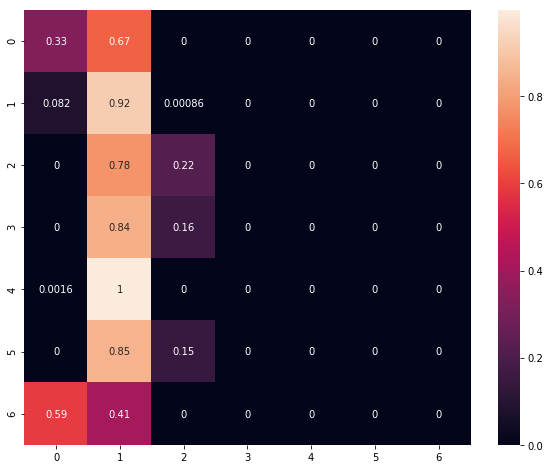

In [275]:
evaluate_confusion(model_dropout, X_test, y_test)

A solid improvement over the previous model, this one still doesn't have much to offer. Let's try a different optimization strategy that Keras implements.

### Adagrad Optimization

This model will use the previous architecture, but this time the optimization strategy will be different.

In [276]:
model_dropout.compile(optimizer=Adagrad(lr=1e-2),
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

model_dropout.reset_states()

history_ada = model_dropout.fit(
    X_train,
    y_train-1,
    epochs=20,
    batch_size=10000,
    verbose=1,
    validation_data=(X_test, y_test-1)
)

Train on 464809 samples, validate on 116203 samples
Epoch 1/20
464809/464809 [==============================] - 6s 13us/step - loss: 0.8613 - acc: 0.6395 - val_loss: 0.6845 - val_acc: 0.7195
Epoch 2/20
464809/464809 [==============================] - 4s 8us/step - loss: 0.7418 - acc: 0.6946 - val_loss: 0.6573 - val_acc: 0.7284
Epoch 3/20
464809/464809 [==============================] - 4s 8us/step - loss: 0.7146 - acc: 0.7049 - val_loss: 0.6462 - val_acc: 0.7325
Epoch 4/20
464809/464809 [==============================] - 4s 8us/step - loss: 0.6983 - acc: 0.7121 - val_loss: 0.6355 - val_acc: 0.7357
Epoch 5/20
464809/464809 [==============================] - 4s 8us/step - loss: 0.6870 - acc: 0.7169 - val_loss: 0.6269 - val_acc: 0.7391
Epoch 6/20
464809/464809 [==============================] - 4s 8us/step - loss: 0.6780 - acc: 0.7196 - val_loss: 0.6200 - val_acc: 0.7402
Epoch 7/20
464809/464809 [==============================] - 4s 8us/step - loss: 0.6718 - acc: 0.7224 - val_loss: 0.6143

F1 score of this model is 0.5258468854406482


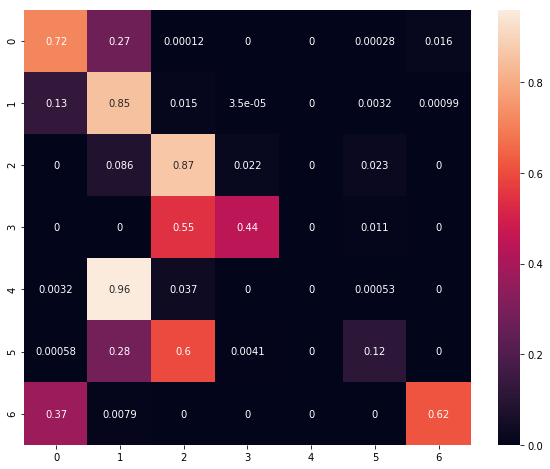

In [277]:
evaluate_confusion(model_dropout, X_test, y_test)

Now we're starting to get somewhere. Adagrad appears to work a bit better. However, it seems like our problem has something to do with a lack of generalizability. What would happen if we added one more layer to each main branch of the network?

### Deeper Learning

In [302]:
X_train = []
X_test = []
inputs = []
wide_branches = []
deep_branches = []

idx_train = np.sort(np.random.choice(np.arange(n_instances), size=n_train, replace=False))
idx_test = np.setdiff1d(np.arange(n_instances), idx_train, assume_unique=True)

y_train = data_subsets['target'].iloc[idx_train].values
y_test = data_subsets['target'].iloc[idx_test].values

for crossed_cat in data_subsets['crossed'].columns:
    input_layer = Input(shape=(1,), dtype='int32', name=crossed_cat)
    inputs.append(input_layer)
    X_train.append(data_subsets['crossed'][crossed_cat].iloc[idx_train].values)
    X_test.append(data_subsets['crossed'][crossed_cat].iloc[idx_test].values)
    
    n_categories = max(X_train[-1])+1
    emb = Embedding(input_dim=n_categories, 
                    output_dim=int(np.sqrt(n_categories)), 
                    input_length=1, name=crossed_cat+'_embed')(input_layer)
    flat = Flatten()(emb)
    wide_branches.append(flat)
    
wide = concatenate(wide_branches, name='wide_root')    
wide_train_1 = Dense(units=20, activation='relu', name='wide_dense_1')(wide)
wide_dropout_1 = Dropout(rate=0.2, name='wide_drop_1')(wide_train_1)
wide_train_2 = Dense(units=20, activation='relu', name='wide_dense_2')(wide_dropout_1)
wide_dropout_2 = Dropout(rate=0.2, name='wide_drop_2')(wide_train_2)

for cat_var in data_subsets['cat_int']:
    input_layer = Input(shape=(1,), dtype='int32', name=cat_var)
    inputs.append(input_layer)
    X_train.append(data_subsets['cat_int'][cat_var].iloc[idx_train].values)
    X_test.append(data_subsets['cat_int'][cat_var].iloc[idx_test].values)
    
    n_categories = max(X_train[-1]) + 1
    emb = Embedding(input_dim=n_categories,
                    output_dim=int(np.sqrt(n_categories)),
                    input_length=1, name=cat_var+'_embed')(input_layer)
    flat = Flatten()(emb)
    deep_branches.append(flat)

num_vars = data_subsets['num']

input_num = Input(shape=(num_vars.shape[1],), name='num_input')
inputs.append(input_num)
X_train.append(data_subsets['num'].iloc[idx_train].values)
X_test.append(data_subsets['num'].iloc[idx_test].values)

num_dense = Dense(units=20, activation='relu', name='num_dense')(input_num)
num_dropout = Dropout(rate=0.2, name='deep_drop')(num_dense)
deep_branches.append(num_dropout)

deep_gather = concatenate(deep_branches, name='deep_concat')
deep_node_1 = Dense(units=80, activation='relu', name='deep1')(deep_gather)
deep_node_1 = Dropout(rate=0.2, name='deep_drop_1')(deep_node_1)
deep_node_2 = Dense(units=50, activation='relu', name='deep2')(deep_node_1)
deep_node_2 = Dropout(rate=0.2, name='deep_drop_2')(deep_node_2)
deep_node_3 = Dense(units=20, activation='relu', name='deep3')(deep_node_2)
deep_node_3 = Dropout(rate=0.2, name='deep_drop_3')(deep_node_3)
deep_node_4 = Dense(units=15, activation='relu', name='deep4')(deep_node_3)
deep_node_4 = Dropout(rate=0.2, name='deep_drop_4')(deep_node_4)


all_gather = concatenate([deep_node_4, wide_dropout_2], name='all_concat')
all_train = Dense(units=20, activation='relu', name='train_all')(all_gather)
all_train = Dropout(rate=0.2, name='all_dropout')(all_train)

final_branch = Dense(units=7, activation='softmax', name='final')(all_train)

model_deeper = Model(inputs=inputs, outputs=final_branch)

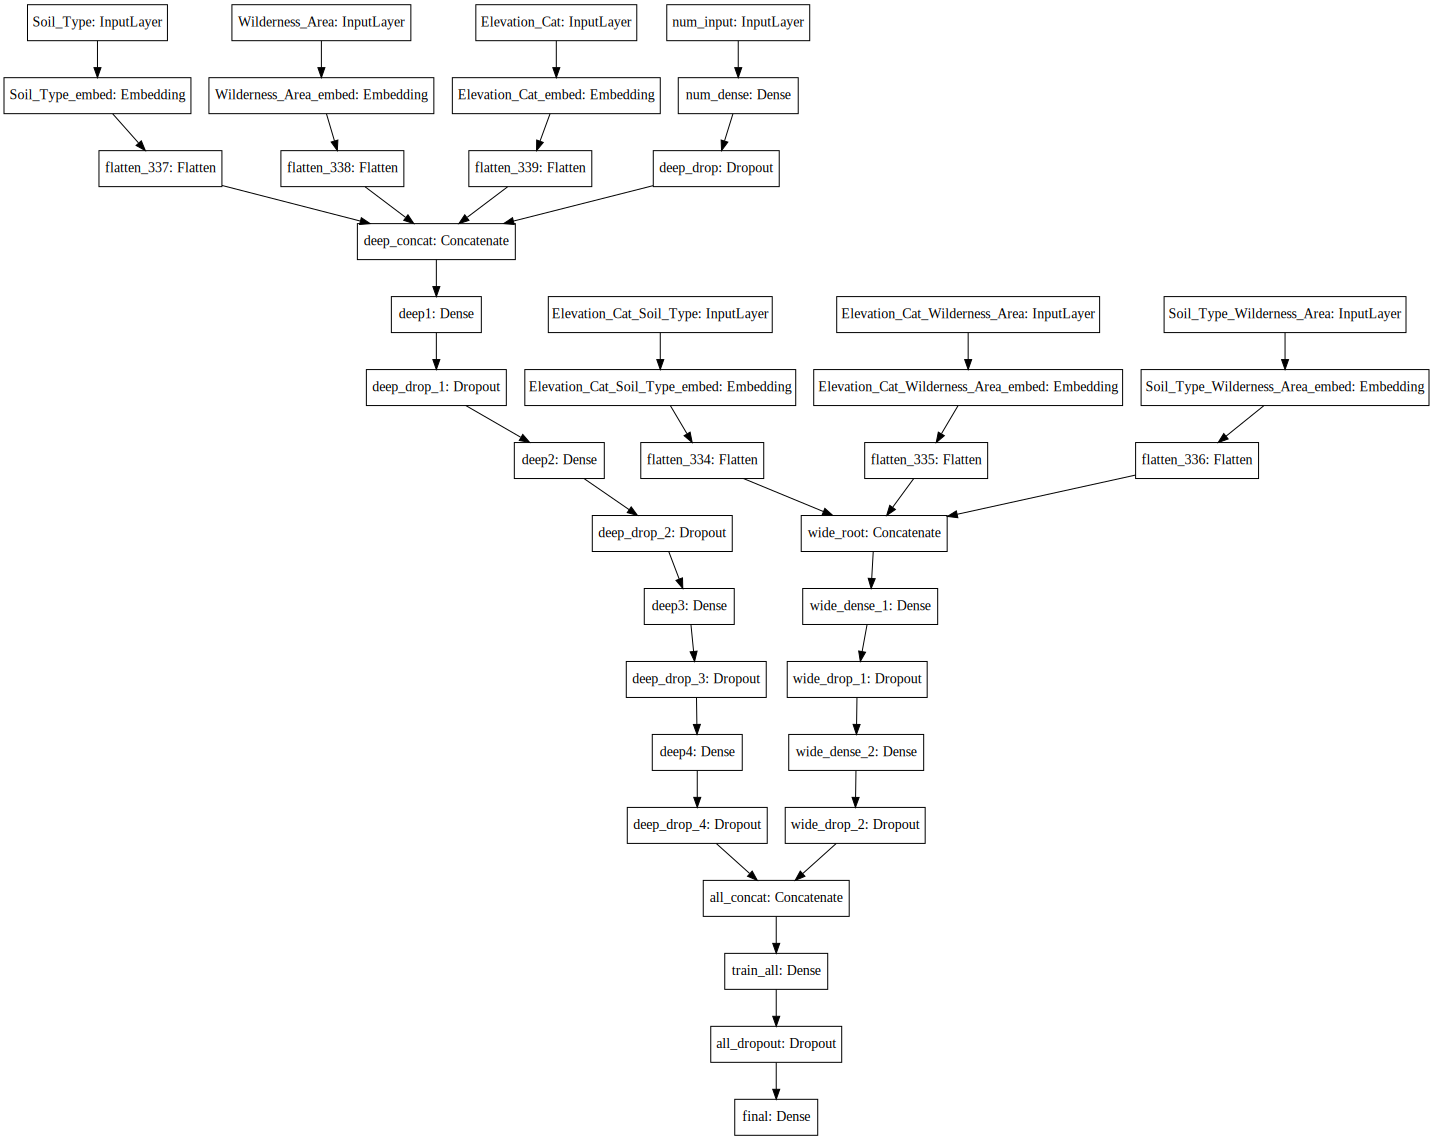

In [303]:
SVG(model_to_dot(model_deeper).create(prog='dot', format='svg'))

Adagrad isn't guaranteed to work better here, but given its success with a similar network, it can't hurt to try.

In [304]:
model_deeper.compile(optimizer=Adagrad(lr=1e-2),
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

model_deeper.reset_states()

history_deep = model_deeper.fit(
    X_train,
    y_train-1,
    epochs=20,
    batch_size=10000,
    verbose=1,
    validation_data=(X_test, y_test-1)
)

Train on 464809 samples, validate on 116203 samples
Epoch 1/20
464809/464809 [==============================] - 7s 16us/step - loss: 1.1063 - acc: 0.5377 - val_loss: 0.7820 - val_acc: 0.6868
Epoch 2/20
464809/464809 [==============================] - 4s 8us/step - loss: 0.8245 - acc: 0.6585 - val_loss: 0.6874 - val_acc: 0.7220
Epoch 3/20
464809/464809 [==============================] - 4s 9us/step - loss: 0.7684 - acc: 0.6806 - val_loss: 0.6694 - val_acc: 0.7242
Epoch 4/20
464809/464809 [==============================] - 4s 9us/step - loss: 0.7446 - acc: 0.6911 - val_loss: 0.6567 - val_acc: 0.7261
Epoch 5/20
464809/464809 [==============================] - 4s 8us/step - loss: 0.7295 - acc: 0.6965 - val_loss: 0.6507 - val_acc: 0.7267
Epoch 6/20
464809/464809 [==============================] - 4s 9us/step - loss: 0.7188 - acc: 0.7024 - val_loss: 0.6441 - val_acc: 0.7288
Epoch 7/20
464809/464809 [==============================] - 4s 9us/step - loss: 0.7102 - acc: 0.7057 - val_loss: 0.6371

F1 score of this model is 0.5236159331701241


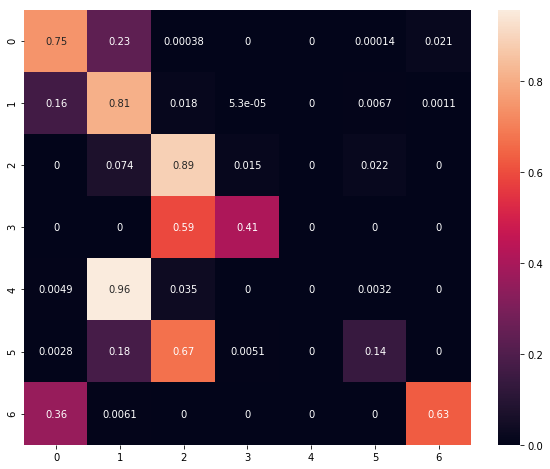

In [305]:
evaluate_confusion(model_deeper, X_test, y_test)

This model achieves a slightly better f1-score than the previous model, but it still has some concerning confusions. For example, nothing is predicted to be class 4, and all but 16% of class 5 is misclassified. Let's try one more related architecture before trying something radically different.

### SeLU Network 

In [289]:
X_train = []
X_test = []
inputs = []
wide_branches = []
deep_branches = []

idx_train = np.sort(np.random.choice(np.arange(n_instances), size=n_train, replace=False))
idx_test = np.setdiff1d(np.arange(n_instances), idx_train, assume_unique=True)

y_train = data_subsets['target'].iloc[idx_train].values
y_test = data_subsets['target'].iloc[idx_test].values

for crossed_cat in data_subsets['crossed'].columns:
    input_layer = Input(shape=(1,), dtype='int32', name=crossed_cat)
    inputs.append(input_layer)
    X_train.append(data_subsets['crossed'][crossed_cat].iloc[idx_train].values)
    X_test.append(data_subsets['crossed'][crossed_cat].iloc[idx_test].values)
    
    n_categories = max(X_train[-1])+1
    emb = Embedding(input_dim=n_categories, 
                    output_dim=int(np.sqrt(n_categories)), 
                    input_length=1, name=crossed_cat+'_embed')(input_layer)
    flat = Flatten()(emb)
    wide_branches.append(flat)
    
wide = concatenate(wide_branches, name='wide_root')    
wide_train_1 = Dense(units=20, activation='selu', name='wide_dense_1')(wide)
wide_train_2 = Dense(units=20, activation='selu', name='wide_dense_2')(wide_train_1)
wide_dropout = Dropout(rate=0.2, name='wide_drop')(wide_train_2)

for cat_var in data_subsets['cat_int']:
    input_layer = Input(shape=(1,), dtype='int32', name=cat_var)
    inputs.append(input_layer)
    X_train.append(data_subsets['cat_int'][cat_var].iloc[idx_train].values)
    X_test.append(data_subsets['cat_int'][cat_var].iloc[idx_test].values)
    
    n_categories = max(X_train[-1]) + 1
    emb = Embedding(input_dim=n_categories,
                    output_dim=int(np.sqrt(n_categories)),
                    input_length=1, name=cat_var+'_embed')(input_layer)
    flat = Flatten()(emb)
    deep_branches.append(flat)

num_vars = data_subsets['num']

input_num = Input(shape=(num_vars.shape[1],), name='num_input')
inputs.append(input_num)
X_train.append(data_subsets['num'].iloc[idx_train].values)
X_test.append(data_subsets['num'].iloc[idx_test].values)

num_dense = Dense(units=20, activation='selu', name='num_dense')(input_num)
num_dropout = Dropout(rate=0.2, name='deep_drop')(num_dense)
deep_branches.append(num_dropout)

deep_gather = concatenate(deep_branches, name='deep_concat')
deep_node_1 = Dense(units=80, activation='selu', name='deep1')(deep_gather)
deep_node_1 = Dropout(rate=0.2, name='deep_drop_1')(deep_node_1)
deep_node_2 = Dense(units=50, activation='selu', name='deep2')(deep_node_1)
deep_node_2 = Dropout(rate=0.2, name='deep_drop_2')(deep_node_2)
deep_node_3 = Dense(units=20, activation='selu', name='deep3')(deep_node_2)
deep_node_3 = Dropout(rate=0.2, name='deep_drop_3')(deep_node_3)
deep_node_4 = Dense(units=15, activation='selu', name='deep4')(deep_node_3)
deep_node_4 = Dropout(rate=0.2, name='deep_drop_4')(deep_node_4)


all_gather = concatenate([deep_node_4, wide_dropout], name='all_concat')
all_train = Dense(units=20, activation='selu', name='train_all')(all_gather)
all_train = Dropout(rate=0.2, name='all_dropout')(all_train)

final_branch = Dense(units=7, activation='softmax', name='final')(all_train)

model_selu = Model(inputs=inputs, outputs=final_branch)

In [290]:
model_selu.compile(optimizer=Adagrad(lr=1e-2),
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

model_selu.reset_states()

history_selu = model_selu.fit(
    X_train,
    y_train-1,
    epochs=20,
    batch_size=10000,
    verbose=1,
    validation_data=(X_test, y_test-1)
)

Train on 464809 samples, validate on 116203 samples
Epoch 1/20
464809/464809 [==============================] - 9s 20us/step - loss: 0.9868 - acc: 0.6084 - val_loss: 0.6742 - val_acc: 0.7197
Epoch 2/20
464809/464809 [==============================] - 5s 11us/step - loss: 0.7777 - acc: 0.6733 - val_loss: 0.6562 - val_acc: 0.7254
Epoch 3/20
464809/464809 [==============================] - 5s 11us/step - loss: 0.7457 - acc: 0.6854 - val_loss: 0.6483 - val_acc: 0.7262
Epoch 4/20
464809/464809 [==============================] - 5s 11us/step - loss: 0.7274 - acc: 0.6921 - val_loss: 0.6436 - val_acc: 0.7285
Epoch 5/20
464809/464809 [==============================] - 5s 11us/step - loss: 0.7163 - acc: 0.6976 - val_loss: 0.6411 - val_acc: 0.7295
Epoch 6/20
464809/464809 [==============================] - 5s 11us/step - loss: 0.7089 - acc: 0.7012 - val_loss: 0.6379 - val_acc: 0.7295
Epoch 7/20
464809/464809 [==============================] - 5s 11us/step - loss: 0.7032 - acc: 0.7030 - val_loss: 

F1 score of this model is 0.5362594648618864


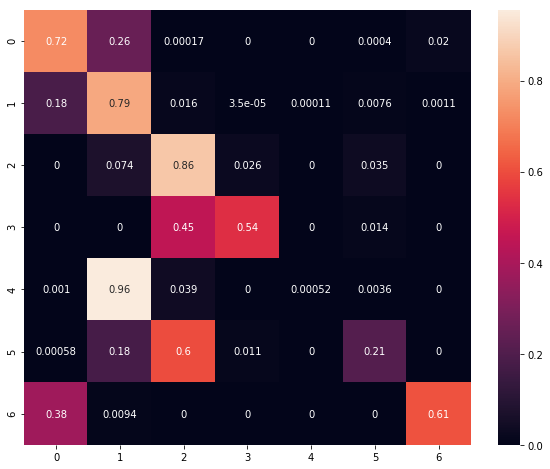

In [291]:
evaluate_confusion(model_selu, X_test, y_test)

The f1-score hasn't changed very much, but this confusion matrix looks slightly less bad. Some of the more egregious confusions have improved. For example, classes 3, 5, and 6 have all improved. Class 4, however, is still a bit of a dumpster fire. More for curiosity than anything else, we reference the data description to see what each class actually is:

0. Spruce/Fir
1. Lodgepole Pine
2. Ponderosa Pine
3. Cottonwood/Willow
4. Aspen
5. Douglas-fir
6. Krummholz

Is it reasonable to confuse conditions in which an Aspen grows for conditions in which a Lodgepole Pine grows? I don't actually know, but it's nice to know what's actually happening here.

Let's now try some more radical architectures.

### All Deep

We guess that our problem is to do with too much memorization, so why not just remove the memorization part entirely?

In [298]:
X_train = []
X_test = []
inputs = []
# wide_branches = []
deep_branches = []

idx_train = np.sort(np.random.choice(np.arange(n_instances), size=n_train, replace=False))
idx_test = np.setdiff1d(np.arange(n_instances), idx_train, assume_unique=True)

y_train = data_subsets['target'].iloc[idx_train].values
y_test = data_subsets['target'].iloc[idx_test].values

for crossed_cat in data_subsets['crossed'].columns:
    input_layer = Input(shape=(1,), dtype='int32', name=crossed_cat)
    inputs.append(input_layer)
    X_train.append(data_subsets['crossed'][crossed_cat].iloc[idx_train].values)
    X_test.append(data_subsets['crossed'][crossed_cat].iloc[idx_test].values)
    
    n_categories = max(X_train[-1])+1
    emb = Embedding(input_dim=n_categories, 
                    output_dim=int(np.sqrt(n_categories)), 
                    input_length=1, name=crossed_cat+'_embed')(input_layer)
    flat = Flatten()(emb)
    deep_branches.append(flat)
    
# wide = concatenate(wide_branches, name='wide_root')    
# wide_train_1 = Dense(units=20, activation='selu', name='wide_dense_1')(wide)
# wide_train_2 = Dense(units=20, activation='selu', name='wide_dense_2')(wide_train_1)
# wide_dropout = Dropout(rate=0.2, name='wide_drop')(wide_train_2)

for cat_var in data_subsets['cat_int']:
    input_layer = Input(shape=(1,), dtype='int32', name=cat_var)
    inputs.append(input_layer)
    X_train.append(data_subsets['cat_int'][cat_var].iloc[idx_train].values)
    X_test.append(data_subsets['cat_int'][cat_var].iloc[idx_test].values)
    
    n_categories = max(X_train[-1]) + 1
    emb = Embedding(input_dim=n_categories,
                    output_dim=int(np.sqrt(n_categories)),
                    input_length=1, name=cat_var+'_embed')(input_layer)
    flat = Flatten()(emb)
    deep_branches.append(flat)

num_vars = data_subsets['num']

input_num = Input(shape=(num_vars.shape[1],), name='num_input')
inputs.append(input_num)
X_train.append(data_subsets['num'].iloc[idx_train].values)
X_test.append(data_subsets['num'].iloc[idx_test].values)

num_dense = Dense(units=20, activation='selu', name='num_dense')(input_num)
num_dropout = Dropout(rate=0.2, name='deep_drop')(num_dense)
deep_branches.append(num_dropout)

deep_gather = concatenate(deep_branches, name='deep_concat')
deep_node_1 = Dense(units=80, activation='selu', name='deep1')(deep_gather)
deep_node_1 = Dropout(rate=0.2, name='deep_drop_1')(deep_node_1)
deep_node_2 = Dense(units=50, activation='selu', name='deep2')(deep_node_1)
deep_node_2 = Dropout(rate=0.2, name='deep_drop_2')(deep_node_2)
deep_node_3 = Dense(units=20, activation='selu', name='deep3')(deep_node_2)
deep_node_3 = Dropout(rate=0.2, name='deep_drop_3')(deep_node_3)
deep_node_4 = Dense(units=15, activation='selu', name='deep4')(deep_node_3)
deep_node_4 = Dropout(rate=0.2, name='deep_drop_4')(deep_node_4)
deep_node_5 = Dense(units=15, activation='selu', name='deep5')(deep_node_4)
deep_node_5 = Dropout(rate=0.2, name='deep_drop_5')(deep_node_5)


# all_gather = concatenate([deep_node_4, wide_dropout], name='all_concat')
# all_train = Dense(units=20, activation='selu', name='train_all')(all_gather)
# all_train = Dropout(rate=0.2, name='all_dropout')(all_train)

# we can also make it a little deeper
final_branch = Dense(units=7, activation='softmax', name='final')(deep_node_5)

model_all_deep = Model(inputs=inputs, outputs=final_branch)

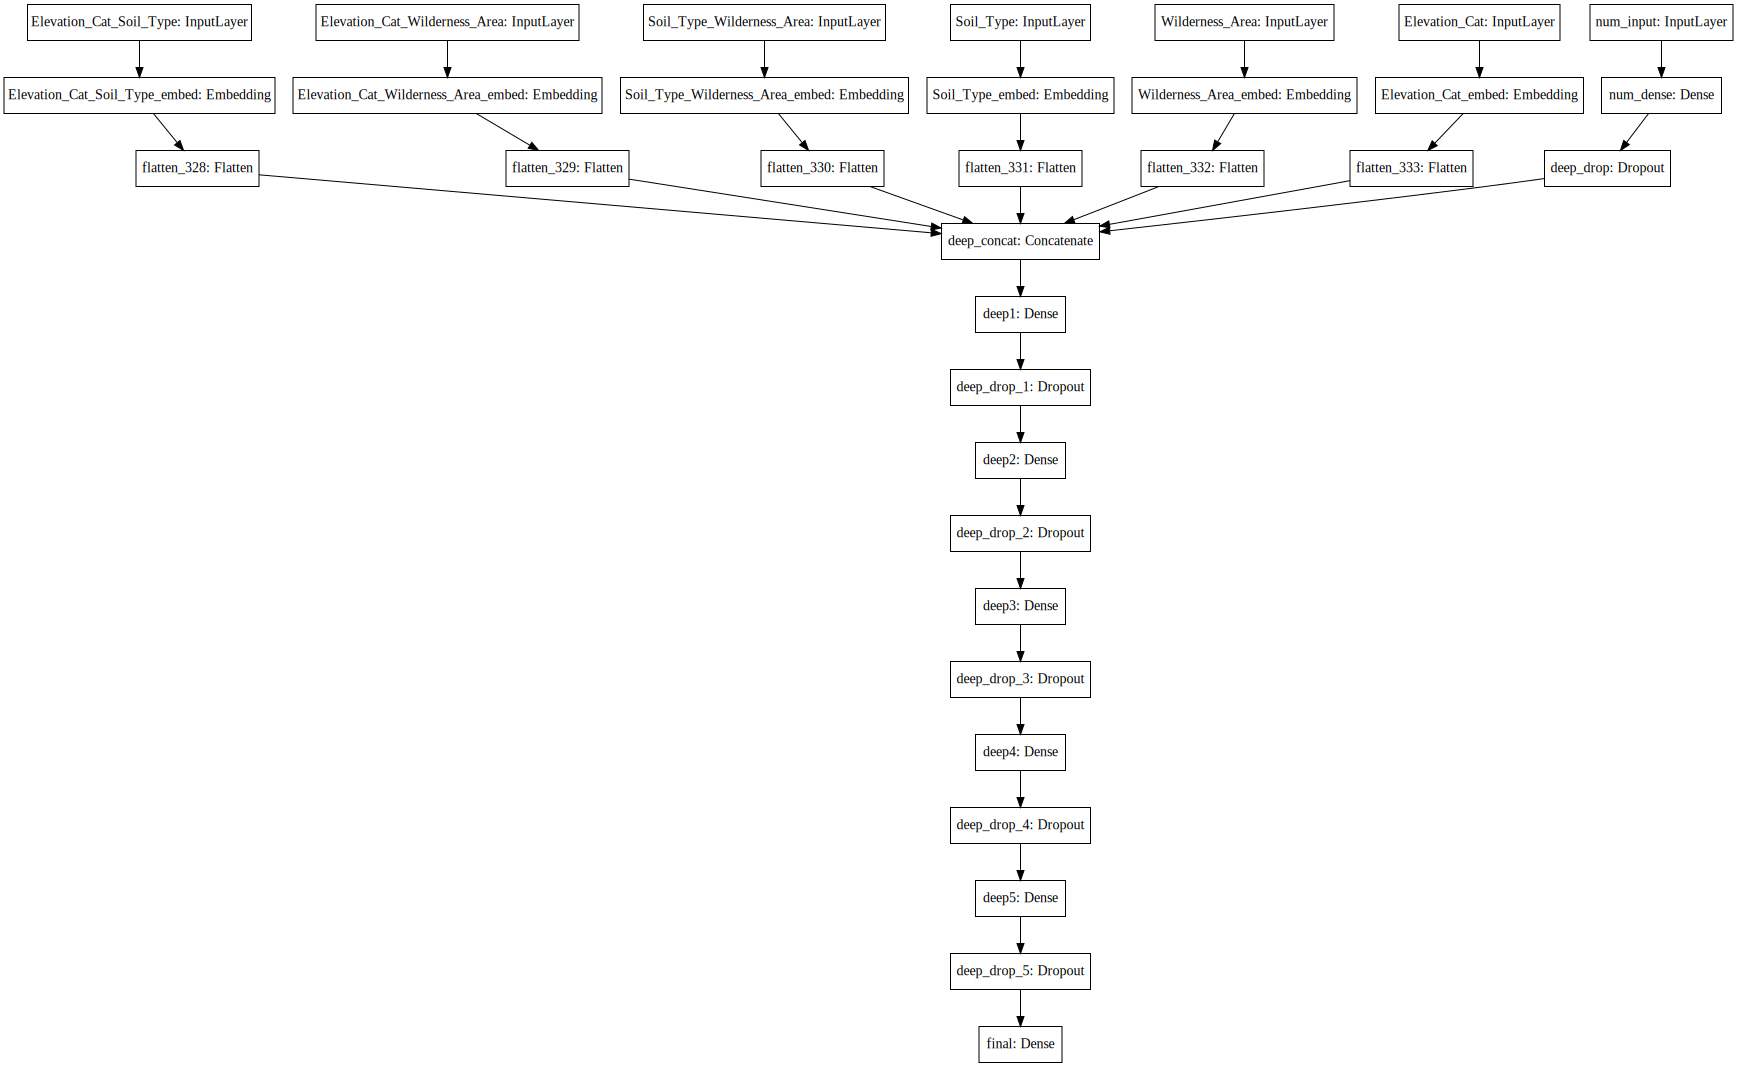

In [299]:
SVG(model_to_dot(model_all_deep).create(prog='dot', format='svg'))

In [300]:
model_all_deep.compile(optimizer=Adagrad(lr=1e-2),
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

model_all_deep.reset_states()

history_all_deep = model_all_deep.fit(
    X_train,
    y_train-1,
    epochs=20,
    batch_size=10000,
    verbose=1,
    validation_data=(X_test, y_test-1)
)

Train on 464809 samples, validate on 116203 samples
Epoch 1/20
464809/464809 [==============================] - 9s 20us/step - loss: 1.1379 - acc: 0.5609 - val_loss: 0.7210 - val_acc: 0.7176
Epoch 2/20
464809/464809 [==============================] - 5s 10us/step - loss: 0.8787 - acc: 0.6436 - val_loss: 0.6997 - val_acc: 0.7220
Epoch 3/20
464809/464809 [==============================] - 5s 10us/step - loss: 0.8325 - acc: 0.6601 - val_loss: 0.6887 - val_acc: 0.7234
Epoch 4/20
464809/464809 [==============================] - 5s 11us/step - loss: 0.8098 - acc: 0.6701 - val_loss: 0.6791 - val_acc: 0.7242
Epoch 5/20
464809/464809 [==============================] - 5s 10us/step - loss: 0.7933 - acc: 0.6760 - val_loss: 0.6777 - val_acc: 0.7233
Epoch 6/20
464809/464809 [==============================] - 4s 9us/step - loss: 0.7818 - acc: 0.6806 - val_loss: 0.6712 - val_acc: 0.7260
Epoch 7/20
464809/464809 [==============================] - 5s 10us/step - loss: 0.7705 - acc: 0.6864 - val_loss: 0

F1 score of this model is 0.4577275261711959


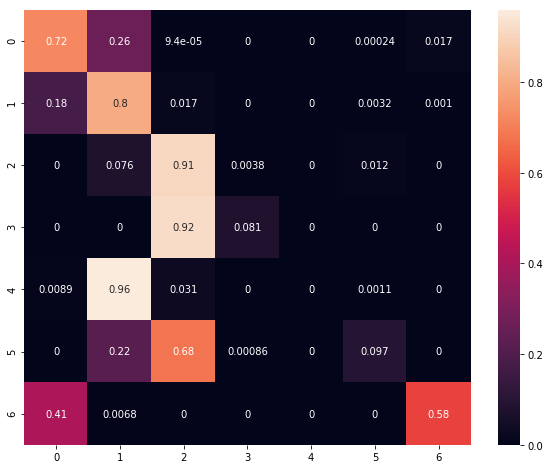

In [301]:
evaluate_confusion(model_all_deep, X_test, y_test)

Well, that one was a bit worse. Not many redeeming characteristics to be found here. Let's try one more slightly unusual model before moving forward and trying to rigorously determine which one is best.

### Side Branches on a Deep Branch

What would happen if we concatenated some of the crossed categorical features into parts of the deep branch in addition to having them as inputs to the wide branch?

In [323]:
X_train = []
X_test = []
inputs = []
wide_branches = []
deep_branches = []

idx_train = np.sort(np.random.choice(np.arange(n_instances), size=n_train, replace=False))
idx_test = np.setdiff1d(np.arange(n_instances), idx_train, assume_unique=True)

y_train = data_subsets['target'].iloc[idx_train].values
y_test = data_subsets['target'].iloc[idx_test].values

cross_names = []
for crossed_cat in data_subsets['crossed'].columns:
    input_layer = Input(shape=(1,), dtype='int32', name=crossed_cat)
    inputs.append(input_layer)
    X_train.append(data_subsets['crossed'][crossed_cat].iloc[idx_train].values)
    X_test.append(data_subsets['crossed'][crossed_cat].iloc[idx_test].values)
    
    cross_names.append(crossed_cat)
    n_categories = max(X_train[-1])+1
    emb = Embedding(input_dim=n_categories, 
                    output_dim=int(np.sqrt(n_categories)), 
                    input_length=1, name=crossed_cat+'_embed')(input_layer)
    flat = Flatten()(emb)
    wide_branches.append(flat)
    
wide = concatenate(wide_branches, name='wide_root')    
wide_train_1 = Dense(units=20, activation='selu', name='wide_dense_1')(wide)
wide_dropout = Dropout(rate=0.2, name='wide_drop')(wide_train_1)

for cat_var in data_subsets['cat_int']:
    input_layer = Input(shape=(1,), dtype='int32', name=cat_var)
    inputs.append(input_layer)
    X_train.append(data_subsets['cat_int'][cat_var].iloc[idx_train].values)
    X_test.append(data_subsets['cat_int'][cat_var].iloc[idx_test].values)
    
    n_categories = max(X_train[-1]) + 1
    emb = Embedding(input_dim=n_categories,
                    output_dim=int(np.sqrt(n_categories)),
                    input_length=1, name=cat_var+'_embed')(input_layer)
    flat = Flatten()(emb)
    deep_branches.append(flat)

num_vars = data_subsets['num']

input_num = Input(shape=(num_vars.shape[1],), name='num_input')
inputs.append(input_num)
X_train.append(data_subsets['num'].iloc[idx_train].values)
X_test.append(data_subsets['num'].iloc[idx_test].values)

num_dense = Dense(units=20, activation='selu', name='num_dense')(input_num)
num_dropout = Dropout(rate=0.2, name='deep_drop')(num_dense)
deep_branches.append(num_dropout)

deep_gather = concatenate(deep_branches, name='deep_concat')
deep_unit_counts = [80, 50, 20]

for i in range(1, data_subsets['crossed'].shape[1]+1):

    if i == 1:
        deep_node = Dense(units=deep_unit_counts[0], activation='selu', name='deep'+str(i))(deep_gather)
    else:
        deep_node = Dense(units=deep_unit_counts[0], activation='selu', name='deep'+str(i))(deep_node)
    
    deep_node = Dropout(rate=0.2, name='deep_drop_'+str(i))(deep_node)
    cross = X_train[i-1]
    X_train.append(cross)
    X_test.append(X_test[i-1])
    
    cross_val = cross_names[i-1]
    deep_side_input = Input(shape=(1,), dtype='int32', name=cross_val+'_branch')
    inputs.append(deep_side_input)
    n_categories = max(X_train[-1]) + 1
    deep_side_embed = Embedding(input_dim=n_categories, 
                    output_dim=int(np.sqrt(n_categories)), 
                    input_length=1, name=cross_val+'_embed_branch')(deep_side_input)
    deep_flat = Flatten()(deep_side_embed)
    deep_node = concatenate([deep_node, deep_flat])

deep_node_4 = Dense(units=15, activation='selu', name='deep4')(deep_node)
deep_node_4 = Dropout(rate=0.2, name='deep_drop_4')(deep_node_4)


all_gather = concatenate([deep_node_4, wide_dropout], name='all_concat')
all_train = Dense(units=20, activation='selu', name='train_all')(all_gather)
all_train = Dropout(rate=0.2, name='all_dropout')(all_train)

final_branch = Dense(units=7, activation='softmax', name='final')(all_train)

model_side_branches = Model(inputs=inputs, outputs=final_branch)

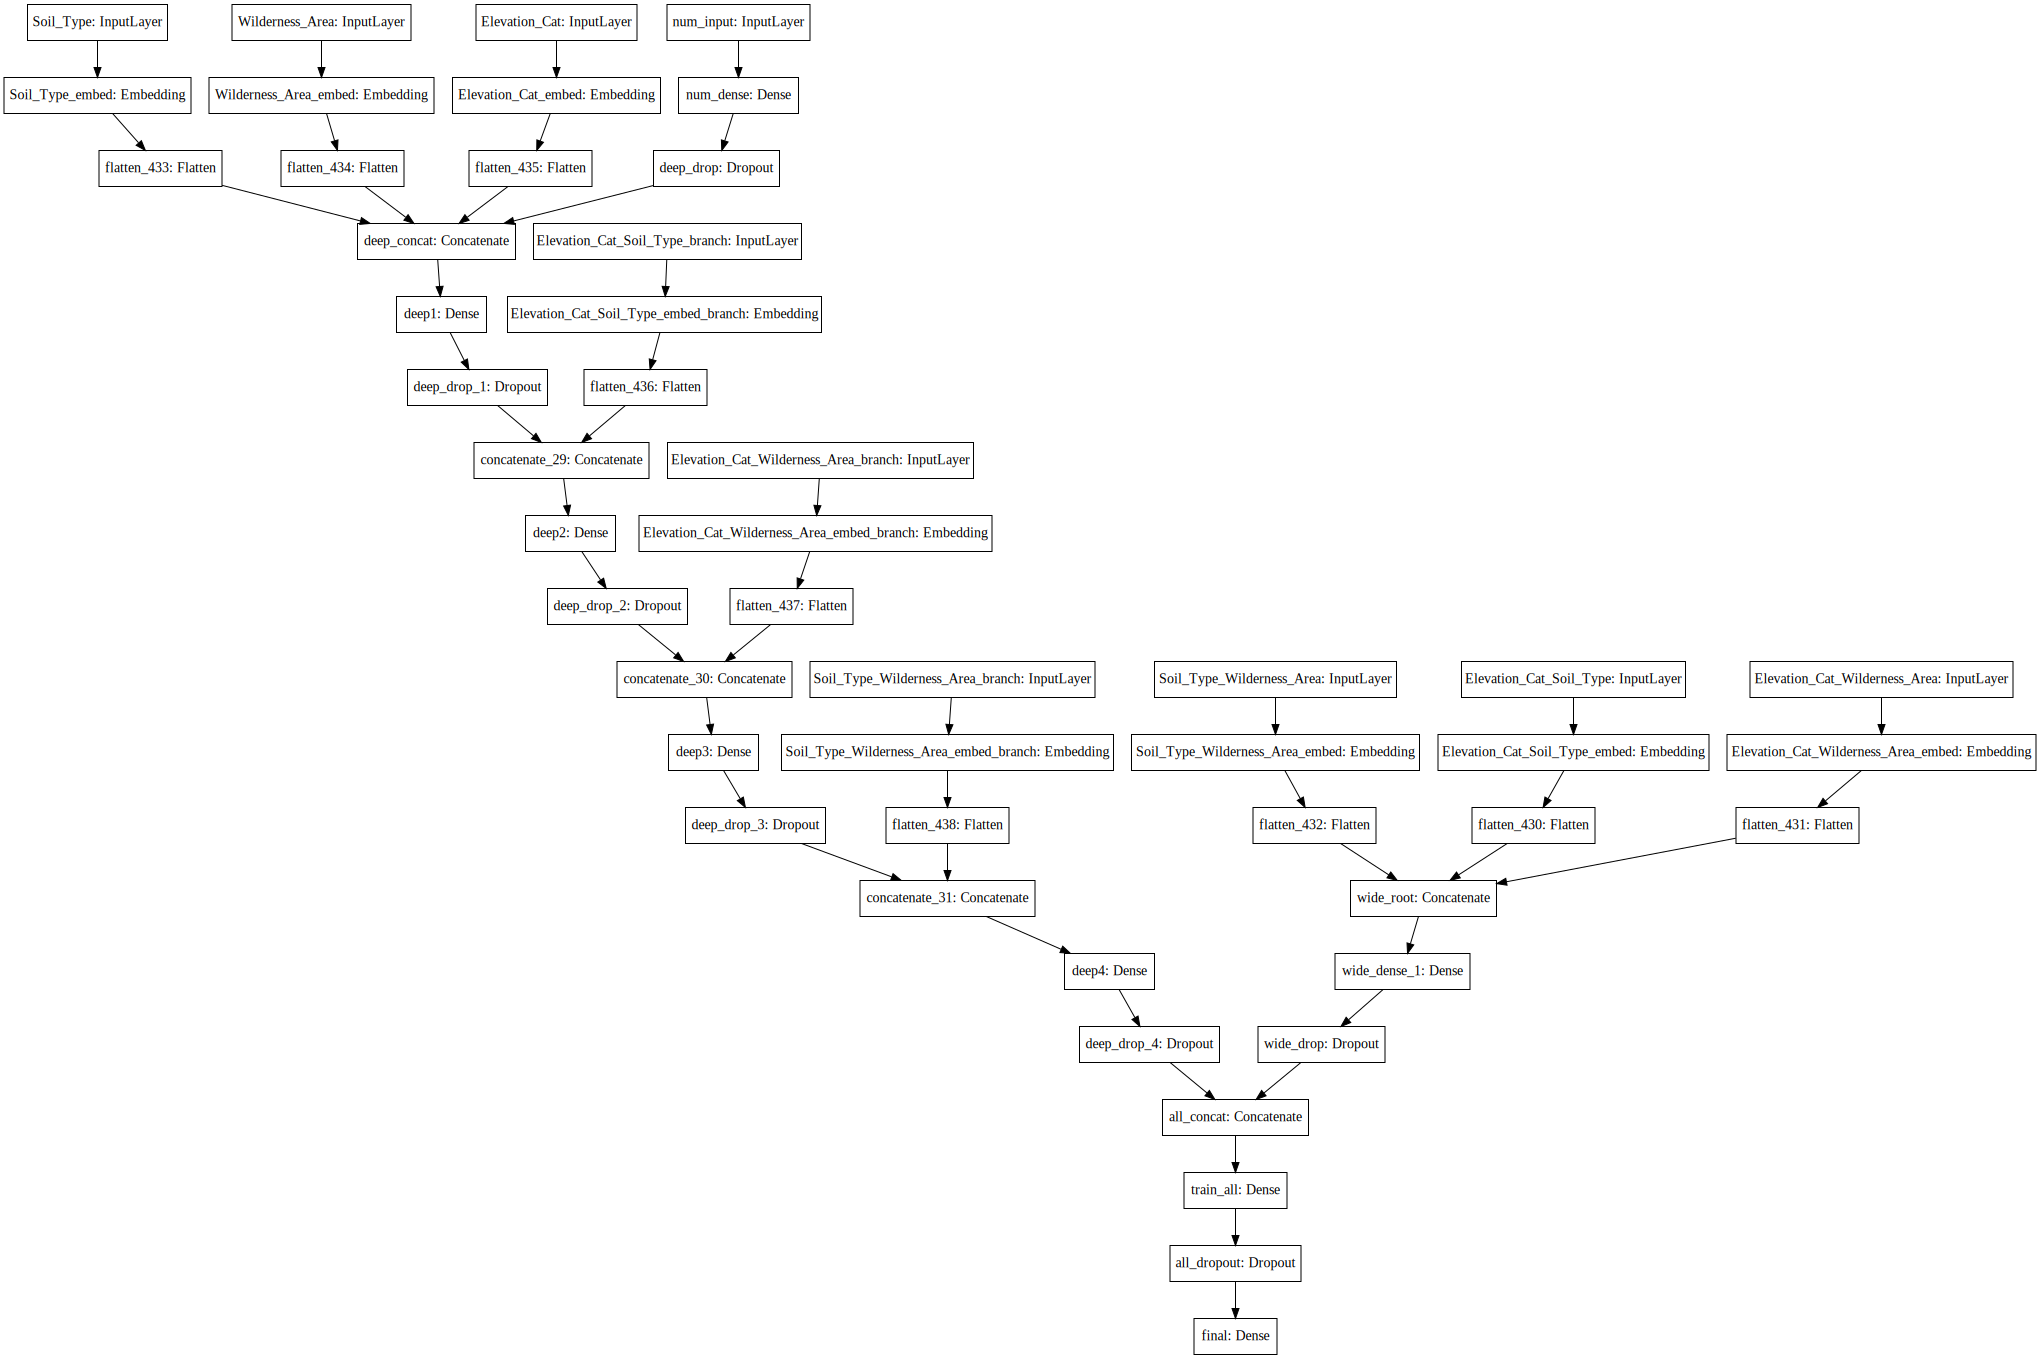

In [324]:
SVG(model_to_dot(model_side_branches).create(prog='dot', format='svg'))

In [325]:
model_side_branches.compile(optimizer=Adagrad(lr=1e-2),
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

model_side_branches.reset_states()

history_side_branches = model_side_branches.fit(
    X_train,
    y_train-1,
    epochs=20,
    batch_size=10000,
    verbose=1,
    validation_data=(X_test, y_test-1)
)

Train on 464809 samples, validate on 116203 samples
Epoch 1/20
464809/464809 [==============================] - 12s 26us/step - loss: 0.9751 - acc: 0.6108 - val_loss: 0.6775 - val_acc: 0.7204
Epoch 2/20
464809/464809 [==============================] - 7s 16us/step - loss: 0.7686 - acc: 0.6788 - val_loss: 0.6540 - val_acc: 0.7256
Epoch 3/20
464809/464809 [==============================] - 7s 15us/step - loss: 0.7355 - acc: 0.6899 - val_loss: 0.6456 - val_acc: 0.7264
Epoch 4/20
464809/464809 [==============================] - 7s 15us/step - loss: 0.7207 - acc: 0.6956 - val_loss: 0.6394 - val_acc: 0.7277
Epoch 5/20
464809/464809 [==============================] - 7s 15us/step - loss: 0.7091 - acc: 0.6994 - val_loss: 0.6359 - val_acc: 0.7304
Epoch 6/20
464809/464809 [==============================] - 7s 15us/step - loss: 0.7030 - acc: 0.7027 - val_loss: 0.6339 - val_acc: 0.7312
Epoch 7/20
464809/464809 [==============================] - 7s 15us/step - loss: 0.6963 - acc: 0.7053 - val_loss:

F1 score of this model is 0.5392548506573728


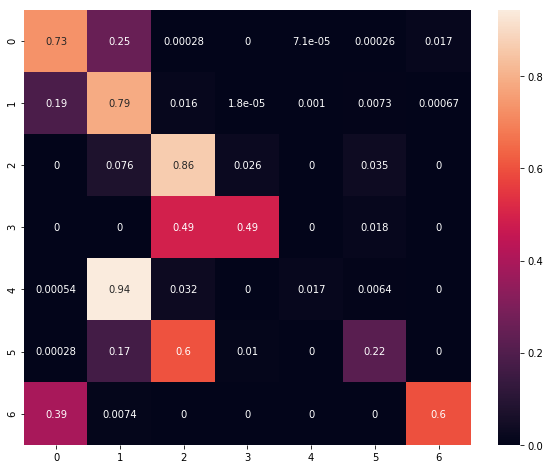

In [326]:
evaluate_confusion(model_side_branches, X_test, y_test)